In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
# getting the data from csv
df_p = pd.read_csv('./Data/Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv')
df_w = pd.read_csv('./Data/export_01.csv')

In [3]:
# preparing weather data
# formating it to the same date shape as pedestrians data
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_w['Year'] = pd.DatetimeIndex(df_w['date']).year
df_w['Month'] = pd.DatetimeIndex(df_w['date']).month
df_w['Month'] = df_w['Month'].apply(lambda x: months[x-1])
df_w['Mdate'] = pd.DatetimeIndex(df_w['date']).day
df_w['Day'] = pd.DatetimeIndex(df_w['date']).dayofweek
df_w['Day'] = df_w['Day'].apply(lambda x: days[x-1])

#exclude > 2019 due to covid
df_w_19 = df_w.loc[df_w.Year <= 2019]

# dropping snow, wpgt, tsun, pres due to too many missing values
df_w_19 = df_w_19.drop(['snow', 'wpgt', 'tsun', 'pres'], axis=1)
# drop NaN values of the rest of the culomns
df_w_19 = df_w_19.dropna()
# preparing for merge
df_w_19['Full_Date'] = df_w_19['Mdate'].astype(str) + ',' + df_w_19['Month'].astype(str)  + ',' +  df_w_19['Year'].astype(str) 

In [4]:
#exclude > 2019 due to covid
df_p_19 = df_p.loc[df_p.Year <= 2019]
df_p_19['Full_Date'] = df_p_19['Mdate'].astype(str) + ',' + df_p_19['Month'].astype(str)  + ',' +  df_p_19['Year'].astype(str) 

df_p_g = df_p_19.groupby(['Full_Date']).sum()
# prepare the daly count of the predestrian wolking
df_p_g.columns = df_p_g.columns.str.replace('Hourly_Counts', 'Daily_Counts')
df_p_g['Daily_Counts'] = (df_p_g['Daily_Counts'] / 100000).astype(int)

# drop columns that are not useful
df_p_g = df_p_g.drop(['Sensor_ID', 'Time', 'Mdate', 'Year', 'ID'], axis=1)

/var/folders/lg/msc95s9d3kvb52s420_7y9b40000gn/T/ipykernel_19148/3328120262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_19['Full_Date'] = df_p_19['Mdate'].astype(str) + ',' + df_p_19['Month'].astype(str)  + ',' +  df_p_19['Year'].astype(str)


In [5]:
df_merge = df_w_19.merge(df_p_g, how='left', on='Full_Date')
# drop Year, Full_Date, Month, Mdate, date to generalize the dataset
df_merge = df_merge.drop(['Year', 'date', 'Full_Date', 'Month', 'Mdate'], axis=1)

df_merge

,tavg,tmin,tmax,prcp,wdir,wspd,Day,Daily_Counts
0,32.7,13.2,40.5,0.0,350.0,22.1,Thursday,3
1,16.8,15.0,23.3,3.2,187.0,22.2,Saturday,3
2,18.7,11.3,24.6,0.0,211.0,14.7,Sunday,4
3,22.7,13.8,30.0,0.0,219.0,15.5,Monday,4
4,14.4,16.3,16.7,2.8,185.0,15.7,Thursday,4
...,...,...,...,...,...,...,...,...
1663,23.7,12.3,29.5,0.0,160.0,13.1,Thursday,7
1664,23.6,16.3,31.8,0.0,256.0,19.4,Friday,7
1665,27.3,15.2,35.2,0.0,207.0,11.2,Saturday,6
1666,26.0,19.5,42.6,0.0,352.0,32.5,Sunday,5


In [6]:
# using OneHotEncoder to format the Day string column into 0/1 columns
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df_merge[['Day']]).toarray())
enc_df.columns = enc.get_feature_names(['Day'])

df_e = df_merge.join(enc_df)
df_e = df_e.drop(['Day'], axis=1)

In [7]:
# generating the test data
x_data = df_e.drop(columns={'Daily_Counts'})
y_data = pd.DataFrame(df_e.Daily_Counts)

# generate training and test sets
x_train, x_test, y_train, y_test = \
    train_test_split(x_data, y_data, test_size=0.3, random_state=42)

# using a Decision Tree as our model
clf = DecisionTreeClassifier(random_state=42, max_depth=3)

clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [10]:
# predicting the amount of pedestrians on the street in 10000
y_predict = clf.predict(x_test)
print('Accuracy Score of our Model: ', accuracy_score(y_test,y_predict))

Accuracy Score of our Model:  0.35129740518962077


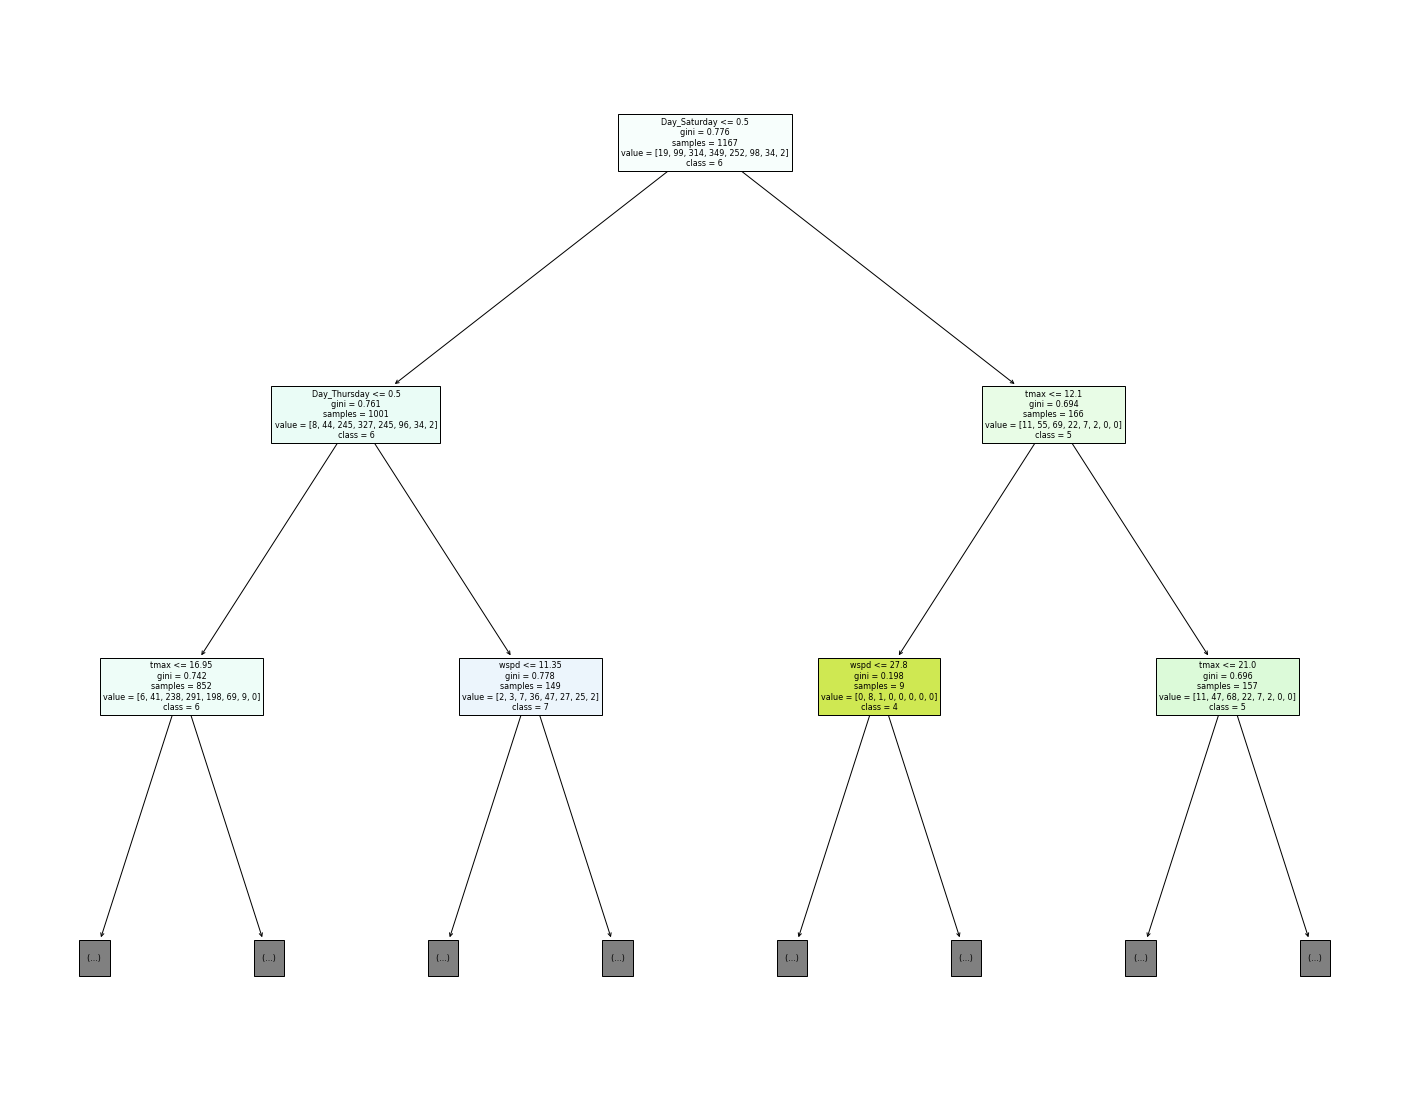

In [9]:
# printing the first 3 depths of our decisition tree
fig = plt.figure(figsize=(25, 20))
target = df_merge['Daily_Counts'].astype(str).unique()
feature_names = list(x_train.columns)
_ =tree.plot_tree(clf,
                    feature_names=feature_names,  
                    class_names=target,
                    filled=True, max_depth=2)